# 0 - Test for GPU
Execute the code below for printing the TF version and testing for GPU availability.

In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.7.0
Found GPU at: /device:GPU:0

Wed Jan 26 13:18:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    59W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# 1 - Prepare data set and generators
We'll start by downloading our data set contained in a zip archive. Execute the code below for downloading and extracting the data to /tmp/bee-vs-wasp.zip.

In [2]:
#@title Download and preprocessing

import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
def unzip(file):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

dataset_file = '/tmp/kaggle_bee_vs_wasp.zip'
download_file_from_google_drive('1-aqpfT73D7HCQGoQEFg-phd3Mtsb9PiP',dataset_file)
unzip('/tmp/kaggle_bee_vs_wasp.zip')

The base directory `/tmp/bee-vs-wasp` contains the subdirectories. Let's define the base directory.

In [3]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

base_dir = '/tmp/kaggle_bee_vs_wasp/'

Get the `labels.csv` of the dataset:

In [4]:
df = pd.read_csv(base_dir+'/labels.csv')
df = df.set_index('id')

# You can perform data set subsampling by adding frac=training_subsample as argument to the sample function, 
# with training_subsample within [0,1].
# For development, you should use a small fraction of the entire data set rater than the full data set, e.g. 0.1.
# For now lets use the whole data set.
training_subsample = 1 
df = df.sample(frac=training_subsample,axis=0)


# Replace \\ in path with / to load images properly
for index in tqdm(df.index):    
    df.loc[index,'path']=df.loc[index,'path'].replace('\\', '/') 
df['path'] = base_dir + df['path']

100%|██████████| 11420/11420 [00:14<00:00, 789.99it/s]



Now we can create the training, validation and test data set by filtering the dataframe.

In [5]:
# Firstly, we create our training set from the dataframe
train_df = df.query("(is_validation==0) and (is_final_validation==0)")
train_classes = train_df["label"]

# Now, we do the same for the valdation set
validation_df = df.query("(is_validation==1) and (is_final_validation==0)")
validation_classes = validation_df["label"]

# Now, we do the same for the test set
test_df = df.query("(is_validation==0) and (is_final_validation==1)")

Now we create our data set generators as learned in the lecture.

In [6]:
#@title Prepare data set generators

from tensorflow.keras.layers.experimental.preprocessing import RandomCrop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

# All images are rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.4,
                                   brightness_range=(.5, 1.5),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
                                   
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
                    train_df,
                    x_col="path",
                    y_col="label",
                    target_size=(224,224),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True,
                    seed=42)

num_classes = 4

# Validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_dataframe(
                    validation_df,
                    x_col="path",
                    y_col="label",
                    target_size=(224,224),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=False)

# Test images using test_datagen generator
test_generator = test_datagen.flow_from_dataframe(
                    test_df,
                    x_col="path",
                    y_col="label",
                    target_size=(224,224),
                    class_mode='categorical',
                    shuffle=False)

train_steps = np.ceil(train_generator.samples / train_generator.batch_size)
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)

print(train_steps)
print(val_steps)

Found 7938 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.
125.0
27.0


# 2 - Get network models and their weights
We now define our models and download their trained weights contained in a zip archive. Execute the code below for downloading and extracting the data.

In [7]:
#@title Define network models

from tensorflow.keras import layers, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


#========================================================== EFFICIENTNETB0 ==========================================================

#---------------------------------------------------------- from scratch -----------------------------------------------------------

def build_efficientnet_from_scratch_model(input_shape, num_classes, summary=True):

  model = EfficientNetB0(include_top=True, weights=None, input_shape=input_shape,classes=num_classes)
  #model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=INITIAL_LEARNING_RATE), metrics=['accuracy'])
  
  return model, _


#========================================================== RESNET50 ==================================================================

#---------------------------------------------------------- pretrained ------------------------------------------------------------

def build_resnet_pretrained_model(input_shape, num_classes, summary=True):

  pre_trained_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

  x = layers.GlobalAveragePooling2D()(pre_trained_model.output)
  output = layers.Dense(num_classes, activation = 'softmax')(x)

  # Define the model
  model = Model(pre_trained_model.input, output, name='res_net_model')
  #model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=INITIAL_LEARNING_RATE), metrics=['accuracy'])
  return model, pre_trained_model

#---------------------------------------------------------- from scratch -----------------------------------------------------------

def build_resnet_from_scratch_model(input_shape, num_classes, summary=True):

  model = ResNet50(include_top=True, weights=None, input_shape=input_shape,classes=num_classes)
  #model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=INITIAL_LEARNING_RATE), metrics=['accuracy'])

  return model, _

In [8]:
#@title Download weights

weights_file = '/tmp/weights.zip'
download_file_from_google_drive('1-r8lhHc0pYoOCMQqXmwde8KpwGDei4Oi',weights_file)
unzip('/tmp/weights.zip')

In [9]:
#@title Apply weights

trainings = ["efficientnet_from_scratch","resnet_from_scratch","resnet_pretrained"]

models = []
for training in trainings:
  if training.__contains__("efficientnet_from_scratch"):
    model, pre_trained_model = build_efficientnet_from_scratch_model((224,224,3), 4)
  elif training.__contains__("resnet_from_scratch"):
    model, pre_trained_model = build_resnet_from_scratch_model((224,224,3), 4)
  elif training.__contains__("resnet_pretrained"):
    model, pre_trained_model = build_resnet_pretrained_model((224,224,3), 4)
  model.load_weights("/tmp/weights/"+training)
  models.append([model,pre_trained_model])

94781440/94765736 [==============================] - 2s 0us/step


# 3 - Define the CAM methods
We now define our CAM methods, which are GradCAM, GradCAM++ and SmoothCAM. Therefore, we also need to specify the last layers of our model.

In [10]:
#@title Define last layers for the CAM methods

def getLastLayerOfModel(model):
  
  layer_name = None
  if model.name.lower().__contains__("res"):
      layer_name="conv5_block3_out"
  elif model.name.lower().__contains__("efficientnet"):
      layer_name="top_activation"
  
  return layer_name

Firstly, we use the methods for `GradCAM` and `GradCAM`++ as proposed in https://github.com/samson6460/tf_keras_gradcamplusplus.

In [11]:
#@title GradCAM

# Copyright 2020 Samson Woof

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from PIL import Image


def grad_cam(model, img_array, layer_name=None, label_name=None, category_id=None):
    """Get a heatmap by Grad-CAM.
    Args:
        model: A model object, build from tf.keras 2.X.
        img_array: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img_array, axis=0)
    
    layer_name = getLastLayerOfModel(model)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        #if label_name:
            #print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap -= np.min(heatmap)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)

In [12]:
#@title GradCAM++

def grad_cam_plus(model, img_array, layer_name=None, label_name=None, category_id=None):
    """Get a heatmap by Grad-CAM++.
    Args:
        model: A model object, build from tf.keras 2.X.
        img_array: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img_array, axis=0)

    layer_name = getLastLayerOfModel(model)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id==None:
                    category_id = np.argmax(predictions[0])
                #if label_name:
                    #print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    
    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_CAM_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return heatmap

def get_imgwithheat(img_path, heatmap, alpha=0.4):
    """Show the image with heatmap.
    Args:
        img_path: string.
        heatmap:  image array, get it by calling grad_cam().
        alpha:    float, transparency of heatmap.
        return_array: bool, return a superimposed image array or not.
    Return:
        None or image array.
    """
    img = cv2.imread(img_path)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = (heatmap_resized*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    #heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + (img)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img)  
    

    return superimposed_img,heatmap_resized

Secondly, we use the method for `ScoreCAM` as proposed in https://github.com/tabayashi0117/Score-CAM.

In [13]:
#@title ScoreCAM

def ScoreCam(model, img_array, layer_name=None,category_id=None, max_N=-1):

    img_array = np.expand_dims(img_array, axis=0)
    if category_id==None:
      cls = np.argmax(model.predict(img_array))
    else:
      cls = category_id
    layer_name = getLastLayerOfModel(model)

    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:]*0.3, weights)
    max_cam = np.max(cam)  
    if max_cam == 0:
        max_cam = 1e-10
    cam /= max_cam
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

def superimpose(img_path, cam, alpha=0.4, emphasize=False):
   
    img_bgr = cv2.imread(img_path)
    
    heatmap_resized = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap_resized = sigmoid(heatmap_resized, 50, 0.5, 1)

        
    heatmap_resized = np.uint8(255 * heatmap_resized)

    heatmap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    #heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + (img_bgr)
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb,heatmap_resized

# 4 - Evaluate CAM methods

Now we want to evaluate the CAM methods for different images of the test data set.

In [14]:
#@title Preprocess and output images

def getGradCamImage(model,img_array,original_img_path):
  heatmap = grad_cam(model, (img_array), label_name = ['bee', 'insect', 'other', 'wasp'],
                   #category_id = 0,)
                  )
  combined_img,resized_heatmap =  get_imgwithheat(original_img_path, heatmap)
  return combined_img,resized_heatmap

def getGradCamPPImage(model,img_array,original_img_path):
  heatmap_plus = grad_cam_plus(model, (img_array))
  combined_img,resized_heatmap =  get_imgwithheat(original_img_path, heatmap_plus)
  return combined_img,resized_heatmap

def getScoreCamImage(model,img_array,original_img_path):
  score_cam=ScoreCam(model,(img_array), max_N=2)
  combined_img,resized_heatmap =  superimpose(original_img_path, score_cam)
  return combined_img,resized_heatmap

In [15]:
#@title Plot the results

import matplotlib.pyplot as plt

def plotResults(img, original_img_path,gt_label,labels=None):
  fig, axs = plt.subplots(3, 4,figsize=(8, 6))

  row_names = ["Image","GradCam","GradCam++","ScoreCam"]
  col_names = ["efficientnet\nfrom scratch","resnet\nfrom scratch","resnet\npretrained"]

  for row_index, row in enumerate(axs):
    imgs = [None] * 4
    heatmaps = [None] * 4

    imgs[0] = image.load_img(original_img_path)
    imgs[1],heatmaps[1] = getGradCamImage(models[row_index][0],img,original_img_path)
    imgs[2],heatmaps[2] = getGradCamPPImage(models[row_index][0],img,original_img_path)
    imgs[3],heatmaps[3] = getScoreCamImage(models[row_index][0],img,original_img_path)

    for col_index,col in enumerate(row):
      col.imshow(imgs[col_index])
      if row_index==0:
        col.set_title(row_names[col_index])
      if col_index==0:
        col.set_ylabel(col_names[row_index])
      col.set_yticks([])
      col.set_xticks([])
      if labels and col_index!=0:
        col.set_xlabel("Prediction:\n"+labels[row_index])
      elif labels and col_index==0:
        col.set_xlabel("Ground Truth:\n"+gt_label)
      
  fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

def plotResultsForResNet(img_array, original_img_path_array,gt_label_array,labels_array=None,labels_on_the_left=True):
  fig, axs = plt.subplots(len(img_array), 4,figsize=(8, len(img_array)*2))

  row_names = ["Image","GradCam","GradCam++","ScoreCam"]
  if labels_on_the_left:
    col_names = ["correct prediction","wrong prediction","wrong prediction"]

  for row_index, row in enumerate(axs):
    imgs = [None] * 4
    heatmaps = [None] * 4

    imgs[0] = image.load_img(original_img_path_array[row_index])
    imgs[1],heatmaps[1] = getGradCamImage(models[2][0],img_array[row_index],original_img_path_array[row_index])
    imgs[2],heatmaps[2] = getGradCamPPImage(models[2][0],img_array[row_index],original_img_path_array[row_index])
    imgs[3],heatmaps[3] = getScoreCamImage(models[2][0],img_array[row_index],original_img_path_array[row_index])

    for col_index,col in enumerate(row):
      col.imshow(imgs[col_index])
      if row_index==0:
        col.set_title(row_names[col_index])
      if col_index==0:
        col.set_ylabel(col_names[row_index])
      col.set_yticks([])
      col.set_xticks([])
      if col_index!=0:
        col.set_xlabel("Prediction:\n"+labels_array[row_index])
      elif col_index==0:
        col.set_xlabel("Ground Truth:\n"+gt_label_array[row_index])
      
  fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [16]:
#@title Get a number of images from a dataframe (either randomly or not)

import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def getImages(df_imgs, num_images, random):

  img_array=[]
  img_array_labels=[]
  img_array_paths=[]

  df_subset = df_imgs.index
  if random:
    df_subset = df_imgs.sample(n=num_images,random_state=1).index

  for index in df_subset:    
    path = df_imgs.loc[index,'path']
    label = df_imgs.loc[index,'label']

    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img *= 1/255
    

    img_array.append(img)
    img_array_labels.append(label)
    img_array_paths.append(path)

  return img_array, img_array_labels, img_array_paths

In [17]:
#@title Evaluation of handselected images

# get all images from test dataset
img_array,img_labels,original_image_paths = getImages(test_df, "All Images", False)

# get array containing all selected meaningful images, then creation of all the CAM map figures of these
# order = [single object correct, multi object correct, false prediction]
wasp_pred = ['/tmp/kaggle_bee_vs_wasp/wasp1/32328655417_7093d0a5c6_n.jpg','/tmp/kaggle_bee_vs_wasp/wasp2/J00301.jpg','/tmp/kaggle_bee_vs_wasp/other_insect/44030802514_729a74b54d_n.jpg']
bee_pred = ['/tmp/kaggle_bee_vs_wasp/bee1/8521248161_8f489b7924_n.jpg','/tmp/kaggle_bee_vs_wasp/bee1/1044467943_594f56bd36_n.jpg','/tmp/kaggle_bee_vs_wasp/other_insect/47738377841_1c9524b60a_n.jpg']
insect_pred = ['/tmp/kaggle_bee_vs_wasp/other_insect/7844777128_f5d5608586_m.jpg','/tmp/kaggle_bee_vs_wasp/other_insect/3808463722_333cdcd90b_n.jpg','/tmp/kaggle_bee_vs_wasp/wasp1/9127908370_8f8b163606_n.jpg']

# [correctly,bee,wasp,insect]
other_pred = ['/tmp/kaggle_bee_vs_wasp/other_noinsect/505978.jpg','/tmp/kaggle_bee_vs_wasp/other_noinsect/527345.jpg','/tmp/kaggle_bee_vs_wasp/other_noinsect/6778651038_294d392627_n.jpg']

1763


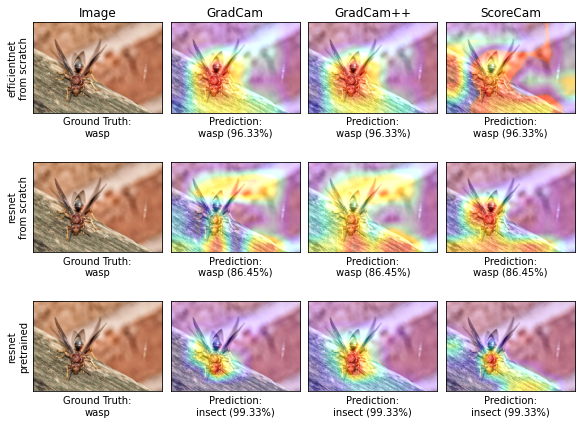

In [18]:
img_idx = -1
#THIS IS FOR SEARCHING CERATAIN IMAGES PREDICTIONS IN THE TEST DATASET
count=10
print(len(img_array))
for nr,img in enumerate(img_array):
  if img_labels[nr] in ['bee','other','wasp']:
    pred = models[2][0].predict_step(np.expand_dims(img,axis=0))
    if np.argmax(pred) == 1:
      #print("found")
      #print(original_image_paths[nr])
      img_idx = nr
      if count==0:
        break
      count-=1


img = img_array[img_idx]
gt_label = img_labels[img_idx]
label_array = ['bee', 'insect', 'other', 'wasp']
predictions = [model[0].predict_step(np.expand_dims(img,axis=0)) for model in models]
labels = [f'{label_array[np.argmax(pred[0])]} ({round(100*float(pred[0][np.argmax(pred[0])]),2)}%)' for pred in predictions]

plotResults(img,original_image_paths[img_idx],gt_label,labels)

In [19]:
#this cell prints out selected images of a class
img_array_for_input = []
labels_array_for_input = []
gt_label_array_for_input = []
original_img_path_array_for_input = []
#change the '*_pred' to the desired class
for picture in other_pred:
  for nr,path in enumerate(original_image_paths):
    if path.__contains__(picture):
      original_img_path_array_for_input.append(original_image_paths[nr])
      img_array_for_input.append(img_array[nr])
      gt_label_array_for_input.append(img_labels[nr])
      label_array = ['bee', 'insect', 'other', 'wasp']
      prediction = models[2][0].predict_step(np.expand_dims(img_array[nr],axis=0))
      labels_array_for_input.append( f'{label_array[np.argmax(prediction[0])]} ({round(100*float(prediction[0][np.argmax(prediction[0])]),2)}%)')

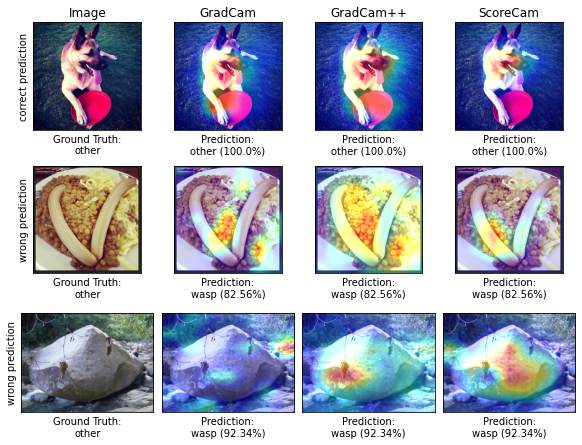

In [20]:
plotResultsForResNet(img_array=img_array_for_input, original_img_path_array=original_img_path_array_for_input,gt_label_array=gt_label_array_for_input,labels_array=labels_array_for_input)

# 5 - Calculatation of the IoU (Unsupervised Task)

Now we want to evaluate the predicted bounding boxes, by comparing them to a small fraction of manually labeled bounding boxes in images.

In [ ]:
#@title Download manually labeled file

download_file_from_google_drive('1i4li8llDYoKBuC2CDAJL3XeEwh9KqxMq',"/tmp/kaggle_bee_vs_wasp/bboxes_labels.zip")
unzip("/tmp/kaggle_bee_vs_wasp/bboxes_labels.zip")

In [ ]:
df_bbox = pd.read_csv("/tmp/bboxes_labels.csv", sep=';')
df_bbox = df_bbox.set_index('id')

# Replace \\ in path with / to load images properly
for index in tqdm(df_bbox.index):    
    df_bbox.loc[index,'path']=df_bbox.loc[index,'path'].replace('\\', '/') 
df_bbox['path'] = base_dir + df_bbox['path']

# Firstly we create our bbox test dataset by filtering the images
df_bbox = df_bbox.query("(bboxes==bboxes)") #no nan values

100%|██████████| 11420/11420 [00:07<00:00, 1462.65it/s]


In [ ]:
#@title Get manual bboxes of image

def getBBoxes(img_path, multiple=True):

  row = df_bbox.loc[df_bbox['path'] == img_path]
  bboxes = []

  has_many = int(row["bboxes"].iloc[0])

  if has_many == 1 and multiple:
    mx_bb = row["mx_bb"].iloc[0].split(",")
    my_bb = row["my_bb"].iloc[0].split(",")
    mw_bb = row["mw_bb"].iloc[0].split(",")
    mh_bb = row["mh_bb"].iloc[0].split(",")

    bboxes = [list([int(val) for val in a]) for a in zip(mx_bb, my_bb, mw_bb, mh_bb)]

  else:
    x_bb = int(row["x_bb"].iloc[0])
    y_bb = int(row["y_bb"].iloc[0])
    w_bb = int(row["w_bb"].iloc[0])
    h_bb = int(row["h_bb"].iloc[0])

    bbox = [x_bb, y_bb, w_bb, h_bb]
    bboxes.append(np.array(bbox))

  return bboxes

In [ ]:
#@title Compute bboxe(s) of CAM

from skimage import filters
from scipy import ndimage
from matplotlib.patches import Rectangle

def compute_bbox(cam):
  mask = cam >= (filters.threshold_otsu(cam) * .95)
  label_im, nb_labels = ndimage.label(mask)

  sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
  # Keep only largest component
  mask = label_im==np.argmax(sizes)
  slice_x, slice_y = ndimage.find_objects(mask)[0]

  # Compute bbox
  bbox = np.array([slice_y.start, 
                   slice_x.start, 
                   slice_y.stop-slice_y.start, 
                   slice_x.stop-slice_x.start])
  bbox = bbox / (2*cam.shape)
  
  return bbox


def compute_bboxes(cam, return_largest=False, ratio_threshold=.01,otsu_threshold=.95):
  mask = cam >= (filters.threshold_otsu(cam) * otsu_threshold)
  label_im, nb_labels = ndimage.label(mask)

  bboxes = list()
  
  if return_largest:
      # Keep only largest component
      sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
      mask = label_im==np.argmax(sizes)
      slice_x, slice_y = ndimage.find_objects(mask)[0]
      # Compute bbox
      bbox = np.array([slice_y.start,
                    slice_x.start, 
                    slice_y.stop-slice_y.start, 
                    slice_x.stop-slice_x.start])
      bbox = bbox / (2*cam.shape)
      bboxes.append(bbox)
  else:
      # Evaluate unique blobs
      parts = sorted(np.unique(label_im))[1:]
      for part in parts:
          mask = label_im==part
          if np.sum(mask)/np.size(mask) < ratio_threshold:
              continue
          slice_x, slice_y = ndimage.find_objects(mask)[0]
          
          # Compute bbox
          bbox = np.array([slice_y.start,
                     slice_x.start, 
                     slice_y.stop-slice_y.start, 
                     slice_x.stop-slice_x.start])
          bbox = bbox / (2*cam.shape)
          bboxes.append(bbox)

  return bboxes

In [ ]:
#@title Calculate IoU

def bboxContains(bbox,pt):
    logic = bbox[0] <= pt[0] < bbox[0]+bbox[2] and bbox[1] <= pt[1] < bbox[1]+bbox[3]
    return logic

def getMatrixOfBBoxes(input_img, bboxes):

  img_size = input_img.shape[:2]
  matrix = (np.zeros(img_size))

  # optimization: only range over bounding boxes and set respective pixel in matrix

  for x in range(img_size[0]):
    for y in range(img_size[1]):
      for bbox in bboxes:
        if bboxContains(bbox,[x,y]):
          matrix[x,y]=1

  return matrix


def calcIoU(input_img, bboxes_gt, bboxes_pred):

  mat_gt = getMatrixOfBBoxes(input_img, bboxes_gt)
  mat_pred = getMatrixOfBBoxes(input_img, bboxes_pred)
  intersect = mat_gt*mat_pred
  union = (mat_gt+mat_pred)-intersect
  IoU = np.sum(intersect)/np.sum(union)
  return IoU

In [ ]:
#@title Plot the results for the IoU of an image

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plotResultsWithBbox(img, original_img_path, gt_label=None ,labels=None):

  fig, axs = plt.subplots(3, 4, figsize=(8, 6))

  row_names = ["Image","GradCam","GradCam++","ScoreCam"]
  col_names = ["efficientnet\nfrom scratch","resnet\nfrom scratch","resnet\npretrained"]

  for row_index, row in enumerate(axs):

    imgs = [None] * 4
    heatmaps = [None] * 4

    imgs[0] = image.load_img(original_img_path)
    imgs[1],heatmaps[1] = getGradCamImage(models[row_index][0], img, original_img_path)
    imgs[2],heatmaps[2] = getGradCamPPImage(models[row_index][0], img, original_img_path)
    imgs[3],heatmaps[3] = getScoreCamImage(models[row_index][0], img, original_img_path)
    
    for col_index, col in enumerate(row):

      if col_index > 0:

        # get ground truth boxes
        bboxes_gt = getBBoxes(original_img_path, True)
        for bbox in bboxes_gt:
          rect_gt = Rectangle(bbox[:2],
                        bbox[2], 
                        bbox[3], 
                        linewidth=2, 
                        edgecolor='g', 
                        facecolor='none')
          col.add_patch(rect_gt)
        
        # get predicted boxes
        bboxes_pred = compute_bboxes(heatmaps[col_index],ratio_threshold=0.01,otsu_threshold=0.95)
        bboxes_pred_abs = []
        for idx, bbox_pred in enumerate(bboxes_pred):

          bbox_pred_abs = bbox_pred * (2*np.asarray(image.load_img(original_img_path)).shape[:2])
          bboxes_pred_abs.append(bbox_pred_abs)
          rect_pred = Rectangle(bbox_pred_abs[:2],
                          bbox_pred_abs[2], bbox_pred_abs[3], 
                          linewidth=2, 
                          edgecolor='r', 
                          facecolor='none')
          col.add_patch(rect_pred)
         
        # calculate and print IoU
        IoU = calcIoU(np.asarray(image.load_img(original_img_path)), bboxes_gt, bboxes_pred_abs)
          
        if labels:
          col.set_xlabel("Prediction:\n"+labels[row_index]+ "\nIoU = "+ str(round(IoU*100,2))+" %")

      # draw the image        
      col.imshow(imgs[col_index])
      if row_index==0:
        col.set_title(row_names[col_index])
      if col_index==0:
        col.set_ylabel(col_names[row_index])
        col.set_xlabel("Ground Truth:\n"+gt_label)
      if col_index==3 and row_index==1:
        legend_elements = [ Patch(facecolor= "None", edgecolor='r', label='Prediction'),
                      Patch(facecolor= "None", edgecolor='g', label='Ground Truth')
                     ]
        col.legend(handles=legend_elements, loc='center left',bbox_to_anchor=(1, 0.5))
        
      col.set_yticks([])
      col.set_xticks([])
  
  fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.1)

def plotResultsWithBboxForResNet(img_array, original_img_path_array,gt_label_array=None,labels_array=None,labels_on_the_left=True):

  fig, axs = plt.subplots(len(img_array), 4,figsize=(8, len(img_array)*2))

  row_names = ["Image","GradCam","GradCam++","ScoreCam"]
  if labels_on_the_left:
    col_names = ["single insect\nclose-up","many insects\nclose-up","single insect\nfar"]

  for row_index, row in enumerate(axs):
    imgs = [None] * 4
    heatmaps = [None] * 4

    imgs[0] = image.load_img(original_img_path_array[row_index])
    imgs[1],heatmaps[1] = getGradCamImage(models[2][0],img_array[row_index],original_img_path_array[row_index])
    imgs[2],heatmaps[2] = getGradCamPPImage(models[2][0],img_array[row_index],original_img_path_array[row_index])
    imgs[3],heatmaps[3] = getScoreCamImage(models[2][0],img_array[row_index],original_img_path_array[row_index])

    
    for col_index, col in enumerate(row):
      if col_index > 0:


        # get ground truth boxes
        bboxes_gt = getBBoxes(original_img_path_array[row_index], True)
        for bbox in bboxes_gt:
          rect_gt = Rectangle(bbox[:2],
                        bbox[2],
                        bbox[3],
                        linewidth=2,
                        edgecolor='g',
                        facecolor='none')
          col.add_patch(rect_gt)
        
        # get predicted boxes
        bboxes_pred = compute_bboxes(heatmaps[col_index],ratio_threshold=0.01,otsu_threshold=0.95)
        bboxes_pred_abs = []
        for idx, bbox_pred in enumerate(bboxes_pred):

          bbox_pred_abs = bbox_pred * (2*np.asarray(image.load_img(original_img_path_array[row_index])).shape[:2])
          bboxes_pred_abs.append(bbox_pred_abs)
          rect_pred = Rectangle(bbox_pred_abs[:2],
                          bbox_pred_abs[2], bbox_pred_abs[3],
                          linewidth=2,
                          edgecolor='r',
                          facecolor='none')
          col.add_patch(rect_pred)
          
        # calculate and print IoU
        IoU = calcIoU(np.asarray(image.load_img(original_img_path_array[row_index])), bboxes_gt, bboxes_pred_abs)
          
        if labels_array:
          if col_index!=0:
            col.set_xlabel("Prediction:\n"+labels_array[row_index]+ "\nIoU = "+ str(round(IoU*100,2))+" %")
          
          # draw the image        
      col.imshow(imgs[col_index])
      if row_index==0:
        col.set_title(row_names[col_index])
      if col_index==0:
        col.set_ylabel(col_names[row_index])
        col.set_xlabel("Ground Truth:\n"+gt_label_array[row_index])
      
      if col_index==3 and row_index==1:
        legend_elements = [ Patch(facecolor= "None", edgecolor='r', label='Prediction'),
                      Patch(facecolor= "None", edgecolor='g', label='Ground Truth')
                     ]
        col.legend(handles=legend_elements, loc='center left',bbox_to_anchor=(1, 0.5))
      col.set_yticks([])
      col.set_xticks([])

In [ ]:
#Get all 60 images stored in arrays
bbox_img_array, bbox_img_labels, bbox_img_paths = getImages(df_bbox, 60, False)

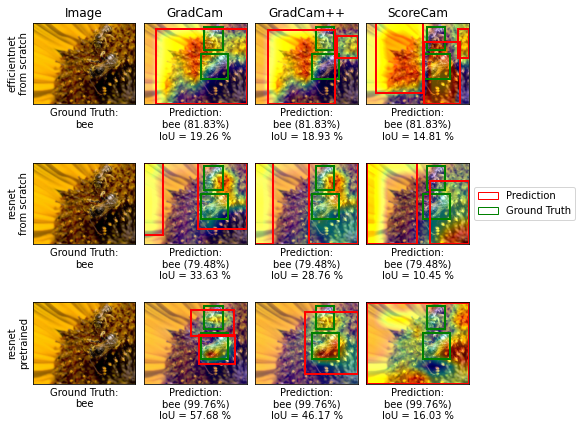

In [ ]:
img_idx = 2

img = bbox_img_array[img_idx]
bbox_img_labels_array = ['bee', 'insect', 'other', 'wasp']
predictions = [model[0].predict_step(np.expand_dims(img,axis=0)) for model in models]
labels = [f'{bbox_img_labels_array[np.argmax(pred[0])]} ({round(100*float(pred[0][np.argmax(pred[0])]),2)}%)' for pred in predictions]
plotResultsWithBbox(img,bbox_img_paths[img_idx],bbox_img_labels[img_idx],labels)

In [ ]:
#@title Evaluation of handselected images

#this cell prints out selected images of a class for the bounding box prediction
img_array_for_input = []
labels_array_for_input = []
gt_label_array_for_input = []
original_img_path_array_for_input = []
for picture in [bbox_img_paths[4],bbox_img_paths[8],bbox_img_paths[9]]:
  for nr,path in enumerate(original_image_paths):
    if path.__contains__(picture):
      original_img_path_array_for_input.append(original_image_paths[nr])
      img_array_for_input.append(img_array[nr])
      gt_label_array_for_input.append(img_labels[nr])
      label_array = ['bee', 'insect', 'other', 'wasp']
      prediction = models[2][0].predict_step(np.expand_dims(img_array[nr],axis=0))
      labels_array_for_input.append( f'{label_array[np.argmax(prediction[0])]} ({round(100*float(prediction[0][np.argmax(prediction[0])]),2)}%)')

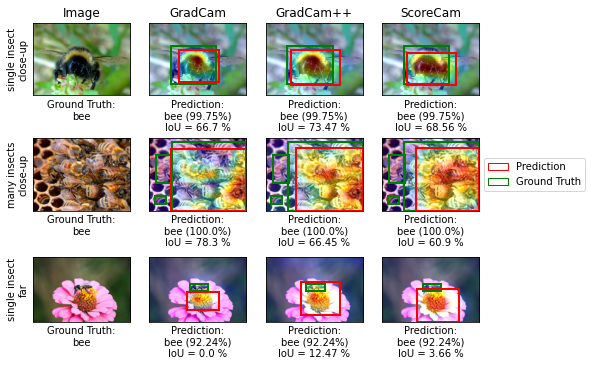

In [ ]:
plotResultsWithBboxForResNet(img_array=img_array_for_input, original_img_path_array=original_img_path_array_for_input,gt_label_array=gt_label_array_for_input,labels_array=labels_array_for_input)

Now we want to evaluate which threshold is best for predicting bounding boxes from the heatmaps, therefore we use the pretrained resnet, run different values and choose the best parameters for the selected 60 images:

In [ ]:
#@title Threshold tests
from itertools import product
def testThresholds(img_array,original_image_paths):

  ratio_thresholds = [0.01,0.025,0.05,0.075,0.1]
  otsu_thresholds = [0.55,0.65,0.75,0.85,0.95]
  threshold_test_results = []  
  for ratio,otsu in product(ratio_thresholds,otsu_thresholds):
    values_gradcam = []
    values_gradcampp = []
    values_scorecam = []
    for i,input_image in tqdm(enumerate(img_array)):

      heatmaps = [None] * 3
      heatmaps[0] = getGradCamImage(models[2][0],input_image,original_image_paths[i])[1]
      heatmaps[1] = getGradCamPPImage(models[2][0],input_image,original_image_paths[i])[1]
      heatmaps[2] = getScoreCamImage(models[2][0],input_image,original_image_paths[i])[1]

      bboxes_gt = getBBoxes(original_image_paths[i])
      

      for j,heatmap in enumerate(heatmaps):
        bboxes_pred = compute_bboxes(heatmap,ratio_threshold=ratio,otsu_threshold=otsu)
        bboxes_pred_abs = []
        for idx, bbox_pred in enumerate(bboxes_pred):
          bbox_pred_abs = bbox_pred * (2*np.asarray(image.load_img(original_image_paths[i])).shape[:2])
          bboxes_pred_abs.append(bbox_pred_abs)
        
        IoU = calcIoU(np.asarray(image.load_img(original_image_paths[i])), bboxes_gt, bboxes_pred_abs)
        if j%3==0:
          values_gradcam.append(IoU)
        elif j%3==1:
          values_gradcampp.append(IoU)
        elif j%3==2:
          values_scorecam.append(IoU)

    threshold_test_results.append([str(round(np.mean(values_gradcam)*100,2))+ " %",str(round(np.mean(values_gradcampp)*100,2))+ " %",str(round(np.mean(values_scorecam)*100,2))+ " %"])
  return threshold_test_results

60it [02:51,  2.85s/it]
60it [02:52,  2.87s/it]
60it [02:48,  2.82s/it]
60it [02:49,  2.83s/it]
60it [02:49,  2.83s/it]
60it [02:48,  2.81s/it]
60it [02:46,  2.77s/it]
60it [03:02,  3.04s/it]
60it [02:50,  2.84s/it]
60it [02:45,  2.75s/it]
60it [02:48,  2.81s/it]
60it [02:48,  2.80s/it]
60it [02:47,  2.79s/it]
60it [02:45,  2.75s/it]
60it [02:44,  2.74s/it]
60it [02:48,  2.80s/it]
60it [02:45,  2.76s/it]
60it [02:47,  2.78s/it]
60it [02:44,  2.73s/it]
60it [02:42,  2.71s/it]
60it [02:46,  2.77s/it]
60it [02:45,  2.76s/it]
60it [02:46,  2.77s/it]
60it [02:45,  2.76s/it]
60it [02:43,  2.72s/it]


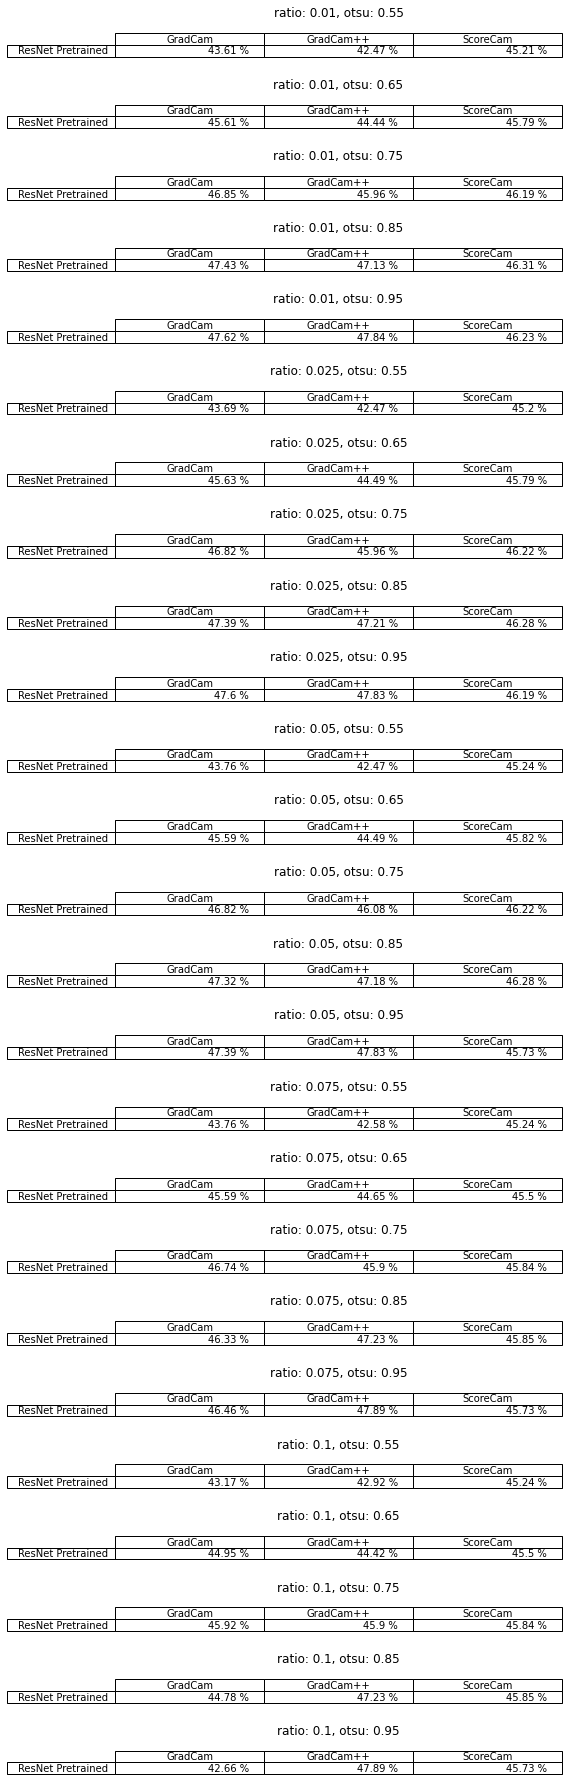

In [ ]:
# Therefore we try out different values for each threshold
ratio_thresholds = [0.01,0.025,0.05,0.075,0.1]
otsu_thresholds = [0.55,0.65,0.75,0.85,0.95]
prod = list(product(ratio_thresholds,otsu_thresholds))

testThresholdsResults = testThresholds(bbox_img_array,bbox_img_paths)

fig, axs = plt.subplots(len(list(testThresholdsResults)),1,figsize=(8,1*len(list(testThresholdsResults))))
# hide axes
fig.patch.set_visible(False)

for i,ax in enumerate(axs):
  ax.axis('off')
  ax.axis('tight')
  the_table = ax.table(cellText=[testThresholdsResults[i]],
                        rowLabels=["ResNet Pretrained"],
                        colLabels= ["GradCam","GradCam++","ScoreCam"],
                        loc='center')
  ax.set_title("ratio: "+str(prod[i][0])+", otsu: "+str(prod[i][1]))

fig.tight_layout()

In [ ]:
float_values = [[float(val.split(" %")[0]) for val in ratios] for ratios in testThresholdsResults]
best_values = np.argmax([np.sum(ratios) for ratios in float_values])
print(prod[best_values])

(0.01, 0.95)


In [ ]:
#@title Calculate the IoUs of each network with the best parameters for the 60 images
def calcIoUofAllImages(img_array,original_image_paths,ratio_threshold,otsu_threshold):
  modelIoUs =[]

  for model in models:
    values_gradcam = []
    values_gradcampp = []
    values_scorecam = []

    for i,input_image in tqdm(enumerate(img_array)):

      heatmaps = [None] * 3
      heatmaps[0] = getGradCamImage(model[0],input_image,original_image_paths[i])[1]
      heatmaps[1] = getGradCamPPImage(model[0],input_image,original_image_paths[i])[1]
      heatmaps[2] = getScoreCamImage(model[0],input_image,original_image_paths[i])[1]

      bboxes_gt = getBBoxes(original_image_paths[i])
      

      for j,heatmap in enumerate(heatmaps):
        bboxes_pred = compute_bboxes(heatmap,ratio_threshold=ratio_threshold, otsu_threshold=otsu_threshold)
        bboxes_pred_abs = []
        for idx, bbox_pred in enumerate(bboxes_pred):
          bbox_pred_abs = bbox_pred * (2*np.asarray(image.load_img(original_image_paths[i])).shape[:2])
          bboxes_pred_abs.append(bbox_pred_abs)
        
        IoU = calcIoU(np.asarray(image.load_img(original_image_paths[i])), bboxes_gt, bboxes_pred_abs)
        if j%3==0:
          values_gradcam.append(IoU)
        elif j%3==1:
          values_gradcampp.append(IoU)
        elif j%3==2:
          values_scorecam.append(IoU)

    modelIoUs.append([str(round(np.mean(values_gradcam)*100,2))+ " %",str(round(np.mean(values_gradcampp)*100,2))+ " %",str(round(np.mean(values_scorecam)*100,2))+ " %"])
  return modelIoUs

60it [03:42,  3.70s/it]
60it [02:50,  2.84s/it]
60it [02:46,  2.77s/it]


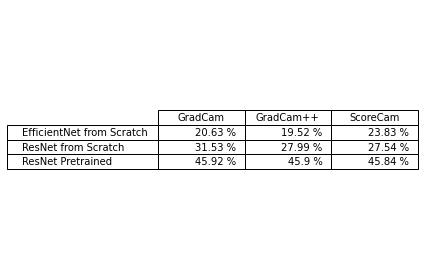

In [ ]:
modelIoUs = calcIoUofAllImages(bbox_img_array,bbox_img_paths,ratio_threshold=prod[best_values][0], otsu_threshold=prod[best_values][1])
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
the_table = plt.table(cellText=modelIoUs,
                      rowLabels=["EfficientNet from Scratch","ResNet from Scratch","ResNet Pretrained"],
                      colLabels= ["GradCam","GradCam++","ScoreCam"],
                      loc='center')

fig.tight_layout()
